In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import jax
import jax.numpy as jnp

from src.spectral_xpci.xscatter import get_delta_beta_mix
from src.spectral_xpci.simulate import get_wavelen, apply_psf, simulate_projection
from chromatix.ops import init_plane_resample
import chromatix.functional as cx

plt.rcParams.update({
    'figure.dpi': 150,
    'font.size':10,
    'axes.titlesize':10,
    'axes.labelsize':8,
    'axes.linewidth': .5,
    'xtick.top': True, 
    'ytick.right': True, 
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'xtick.labelsize':8,
    'ytick.labelsize':8,
    'legend.fontsize': 8,
    'lines.linewidth':1,
    'image.cmap':'gray'
    })

def add_scalebar(ax, sz, Nx, real_dx, real_units):
    width_px = sz * Nx 
    label = f'{real_dx * width_px:.0f} {real_units}'
    scalebar = AnchoredSizeBar(ax.transData, width_px, label, 'lower left', size_vertical=1, frameon=False)
    ax.add_artist(scalebar)

class Material:
    def __init__(self, name, matcomp, density):
        self.name = name
        self.matcomp = matcomp
        self.density = density
    def delta_beta(self, energy):
        delta, beta = get_delta_beta_mix(self.matcomp, np.atleast_1d(energy), self.density)
        return delta.squeeze(), beta.squeeze()

tissue = Material('tissue', 'H(10.2)C(14.3)N(3.4)O(70.8)Na(0.2)P(0.3)S(0.3)Cl(0.2)K(0.3)', 1.06)
bone = Material('bone', 'H(3.4)C(15.5)N(4.2)O(43.5)Na(0.1)Mg(0.2)P(10.3)S(0.3)Ca(22.5)', 1.92)
fat = Material('adipose', 'H(11.4)C(59.8)N(0.7)O(27.8)Na(0.1)S(0.1)Cl(0.1)', 0.95)
alu = Material('aluminum', 'Al(100.0)', 2.699)
pmma = Material('PMMA', 'H(8.06)C(59.98)O(31.96)', 1.19)
water = Material('water', 'H(11.2)O(88.8)', 1.0)
calcium = Material('calcium', 'Ca(100.0)', 1.526)

# Parameters
- All distances are in units [m]
- All energies in [keV]

In [2]:
propdist = 500e-3       
energy = 20
I0 = 1e5  # beam intensity -- effects noise (smaller = noiser)

### Phantom:
phantom_N = 4096
phantom_dx = 10e-6
fov = phantom_N*phantom_dx
z_slices = 10
phantom_dz = fov/z_slices
phantom_shape = jnp.array([z_slices, phantom_N, phantom_N])
print(f'total field of view = {fov*1e2:.3f} cm')
print(f'{1e6*phantom_dx:.2f}-um phantom px', phantom_shape, f'({phantom_N**2 * z_slices * 4/1e6:.6f} MB)')

### Detector:
det_shape = (1024, 1024)               
det_dx = fov / det_shape[0]
det_psf = 'lorentzian'  
det_fwhm = 1e-6
print(f'{1e6*det_dx:.2f}-um det px', det_shape)

### Misc:
key = jax.random.PRNGKey(42)
Nx = phantom_shape[0]
dz = phantom_dx
N_pad = 100
n_medium = 1  # vacuum  (for free-space propagation)
n_avg = 1  # for multislice, check?
det_resample_func = init_plane_resample(det_shape, (det_dx, det_dx), resampling_method='linear')


total field of view = 4.096 cm
10.00-um phantom px [  10 4096 4096] (671.088640 MB)
40.00-um det px (1024, 1024)


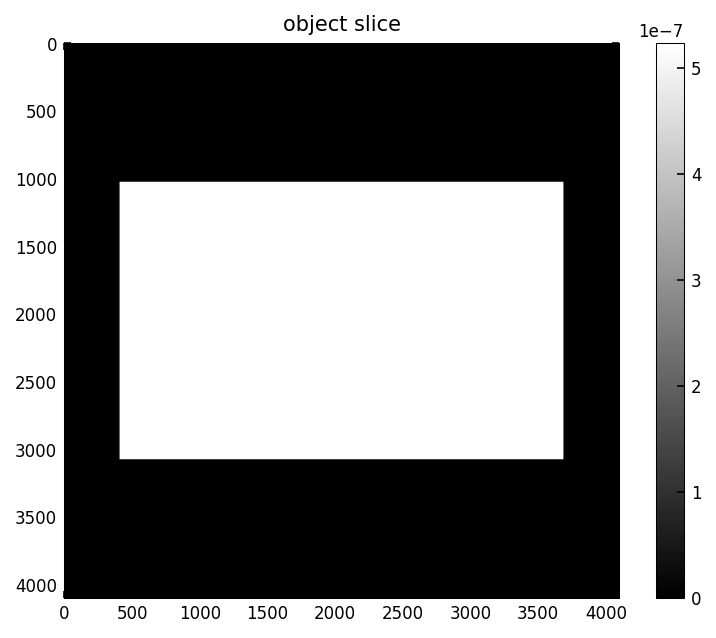

CPU times: user 7.87 s, sys: 1.99 s, total: 9.86 s
Wall time: 7.08 s


In [3]:
%%time

# Make simple phantom:
coords_xy = np.abs(np.linspace(-phantom_N/2, phantom_N/2, phantom_N))
X, Y = np.meshgrid(coords_xy, coords_xy)
obj = np.zeros(phantom_shape, dtype=jnp.uint8)
for z in range(z_slices):  # lazy, fix
    mask = np.where((X <= 0.4*phantom_N) & (Y <= 0.25*phantom_N))  # some arbitrary rect
    obj[z][mask] = 1

# Assign delta and beta values to each voxel:
matdict = {1: water}
obj_delta = jnp.zeros(obj.shape)
obj_beta = jnp.zeros(obj.shape)
for mat_id in matdict:
    d, b = matdict[mat_id].delta_beta(energy)
    obj_delta = obj_delta.at[obj == mat_id].set(d)
    obj_beta = obj_beta.at[obj == mat_id].set(b)

plt.title('object slice')
plt.imshow(obj_delta[0,:,:])
plt.colorbar()
plt.show()


# Projection approx

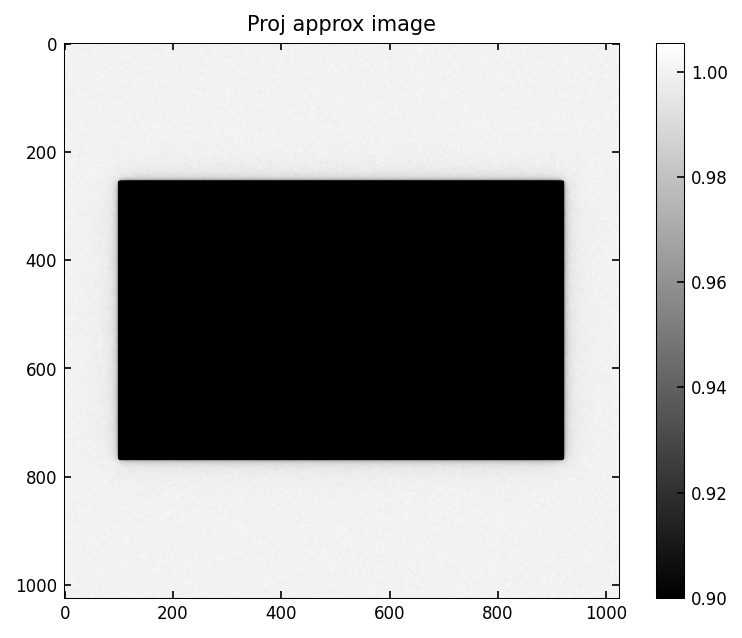

CPU times: user 3min 11s, sys: 1.27 s, total: 3min 12s
Wall time: 15.6 s


In [5]:
%%time

beta_proj = phantom_dz * jnp.sum(obj_beta, axis=0)
delta_proj = phantom_dz * jnp.sum(obj_beta, axis=0)
img_approx = simulate_projection(beta_proj, delta_proj, phantom_dx, det_shape, det_dx, det_fwhm, energy, propdist, I0)  

plt.title('Proj approx image')
plt.imshow(img_approx, vmin=0.9)
plt.colorbar()
plt.show()

# Multislice

I don't have an existing function for this like I do for the proj approx, so I use some of the chromatix pipeline here.

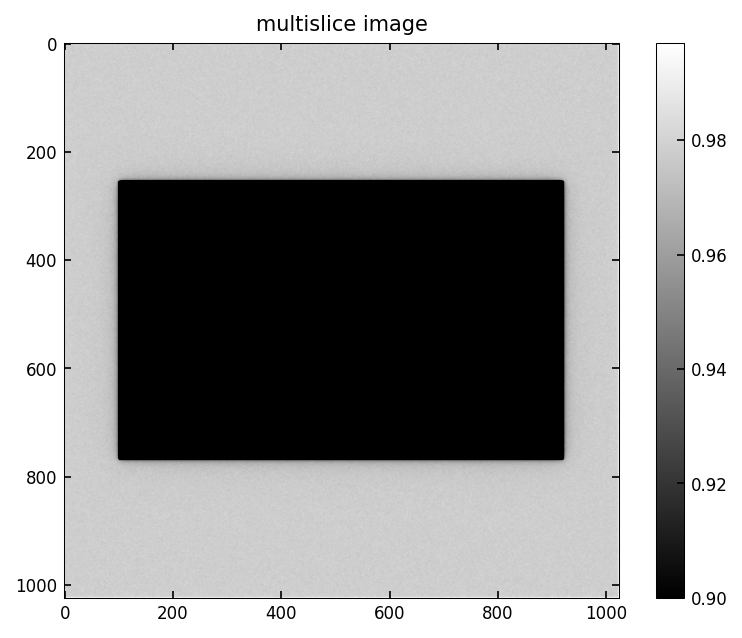

CPU times: user 3min 18s, sys: 3.72 s, total: 3min 21s
Wall time: 20.5 s


In [6]:
%%time

field = cx.plane_wave(
    shape = phantom_shape[1:], 
    dx = phantom_dx,
    spectrum = get_wavelen(energy),
    spectral_density = 1.0,
)
field = field / field.intensity.max()**0.5  # normalize
cval = field.intensity.max()

# modulate field thru sample
exit_field = cx.multislice_thick_sample(field, obj_beta, obj_delta, n_avg, phantom_dz, N_pad)

# propagate thru free space to the detector
det_field = cx.transfer_propagate(exit_field, propdist, n_medium, N_pad, cval=cval, mode='same')

# resample from phantom resolution -> detector resolution (pixel sizes don't necessarily match)
det_resample_func = init_plane_resample(det_shape, (det_dx, det_dx), resampling_method='linear')
img_ms = det_resample_func(det_field.intensity.squeeze()[...,None,None], field.dx.ravel()[:1])[...,0,0]
img_ms /= img_ms.ravel()[0] 

# add noise and PSF blur
img_ms = jax.random.poisson(key, I0*img_ms, img_ms.shape) / I0 # noise
img_ms = apply_psf(img_ms, fov, det_dx, psf=det_psf, fwhm=det_fwhm, kernel_width=0.1)

plt.title('multislice image')
plt.imshow(img_ms, vmin=0.9)
plt.colorbar()
plt.show()